What is the plan?
Strategy:
- Focus on highly liquid securitues; Ensure assets have average daily volumes exceeding a certain threshold
- Momentum metric; Compute cumulative returns over past 3-5 trading days and set a threshold
- Volume confirmation; Include only assets where current 3-day average volume exceeds the 20-day moving average volume by 20% or more



In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Constants
LOOKBACK_DAYS = 30  # Period for calculating momentum and correlation
MIN_AVERAGE_VOLUME = 1000000  # Minimum average volume for liquidity filter
MOMENTUM_THRESHOLD = 0.02  # Minimum return over the lookback period for momentum
MAX_SELECTED_STOCKS = 30  # Maximum number of stocks to select

def calculate_allocation_and_targets(selected_stocks, stock_data, portfolio_size):
    """
    Calculate the number of shares to buy, stop-loss prices, and profit targets for selected stocks.
    
    Parameters:
        selected_stocks (list): List of selected diversified stocks.
        stock_data (DataFrame): Historical stock data.
        portfolio_size (float): Total capital available for the portfolio.

    Returns:
        pd.DataFrame: A DataFrame with stock allocations, stop-loss prices, and profit targets.
    """
    allocations = []
    equal_allocation = portfolio_size / len(selected_stocks)  # Allocate equally among stocks

    for ticker in selected_stocks:
        try:
            # Get the most recent closing price
            current_price = stock_data[ticker]['Adj Close'].iloc[-1]

            # Calculate the number of shares to buy
            shares_to_buy = int(equal_allocation / current_price)

            # Calculate stop-loss and profit target prices
            stop_loss = current_price * 0.98  # 2% below the purchase price
            profit_target = current_price * 1.05  # 5% above the purchase price

            # Add the stock's allocation details to the list
            allocations.append({
                'Stock': ticker,
                'Current Price': current_price,
                'Shares to Buy': shares_to_buy,
                'Stop-Loss Price': stop_loss,
                'Profit Target': profit_target
            })
        except Exception as e:
            print(f"Error calculating allocation for {ticker}: {e}")
    
    # Return the allocation details as a DataFrame
    return pd.DataFrame(allocations)


def get_sp500_tickers():
    """
    Fetch the list of S&P 500 tickers from Wikipedia.
    """
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(url, header=0)  # Read tables from the page
    sp500 = table[0]  # First table contains the tickers
    tickers = sp500['Symbol'].tolist()  # Get the 'Symbol' column as a list
    return tickers


def fetch_data(tickers):
    """
    Fetch historical stock data for the given tickers using yfinance.
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=(LOOKBACK_DAYS + 30))  # Add buffer for non-trading days
    data = yf.download(tickers, start=start_date, end=end_date, interval='1d', group_by='ticker')
    return data

def filter_stocks(data):
    """
    Filter stocks based on entry rules: momentum and average volume.
    """
    filtered_stocks = []
    for ticker in data.columns.levels[0]:
        try:
            stock_data = data[ticker].copy()
            stock_data.loc[:, 'Daily Return'] = stock_data['Adj Close'].pct_change()  # Avoid SettingWithCopyWarning
            
            # Ensure enough rows for lookback
            if len(stock_data) < LOOKBACK_DAYS:
                print(f"Not enough data for {ticker}. Skipping...")
                continue
            
            # Calculate momentum
            momentum = (stock_data['Adj Close'].iloc[-1] / stock_data['Adj Close'].iloc[-LOOKBACK_DAYS]) - 1
            
            # Calculate average volume
            avg_volume = stock_data['Volume'].mean()
            
            # Apply filters
            if momentum > MOMENTUM_THRESHOLD and avg_volume > MIN_AVERAGE_VOLUME:
                filtered_stocks.append(ticker)
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    return filtered_stocks

def compute_risk_adjusted_correlation(filtered_stocks, data):
    """
    Compute risk-adjusted correlation matrix for the filtered stocks.
    """
    returns = pd.DataFrame()
    for ticker in filtered_stocks:
        returns[ticker] = data[ticker]['Adj Close'].pct_change()
    returns = returns.dropna()
    
    # Calculate volatility
    volatility = returns.std()
    
    # Covariance matrix
    cov_matrix = returns.cov()
    
    # Risk-adjusted correlation matrix
    risk_adj_corr = cov_matrix / (volatility.values[:, None] * volatility.values[None, :])
    return risk_adj_corr

def select_stocks(risk_adj_corr, max_stocks=MAX_SELECTED_STOCKS):
    """
    Select stocks with the lowest average correlation for diversification.
    """
    # Compute average correlation for each stock
    avg_corr = risk_adj_corr.mean(axis=1)
    selected_stocks = avg_corr.sort_values().head(max_stocks).index.tolist()
    return selected_stocks

# Main Script
if __name__ == "__main__":
    print("Fetching S&P 500 tickers...")
    sp500_tickers = get_sp500_tickers()
    
    print("Downloading historical stock data...")
    stock_data = fetch_data(sp500_tickers)
    
    print("Filtering stocks based on entry rules...")
    filtered_stocks = filter_stocks(stock_data)
    print(f"Filtered stocks: {filtered_stocks}")
    
    print("Computing risk-adjusted correlation matrix...")
    risk_adj_corr = compute_risk_adjusted_correlation(filtered_stocks, stock_data)
    print("Risk-Adjusted Correlation Matrix:")
    print(risk_adj_corr)
    
    print("Selecting diversified stocks...")
    diversified_stocks = select_stocks(risk_adj_corr)
    print(f"Selected diversified stocks: {diversified_stocks}")

# Define your total portfolio size
portfolio_size = 1000000  # Example: $100,000

print("Calculating allocations and targets...")
allocations_df = calculate_allocation_and_targets(diversified_stocks, stock_data, portfolio_size)
print(allocations_df)



Fetching S&P 500 tickers...


[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2024-10-03 21:28:37.145394 -> 2024-12-02 21:28:37.145394)')


Filtering stocks based on entry rules...


/tmp/ipykernel_69118/3646413218.py:82: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_data.loc[:, 'Daily Return'] = stock_data['Adj Close'].pct_change()  # Avoid SettingWithCopyWarning
/tmp/ipykernel_69118/3646413218.py:82: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_data.loc[:, 'Daily Return'] = stock_data['Adj Close'].pct_change()  # Avoid SettingWithCopyWarning


Filtered stocks: ['A', 'ADBE', 'ADP', 'ADSK', 'AEE', 'ALB', 'ALL', 'AME', 'AMZN', 'AON', 'APH', 'AXP', 'BAC', 'BEN', 'BK', 'BKR', 'BMY', 'BRO', 'BSX', 'BX', 'C', 'CAH', 'CAT', 'CBRE', 'CCL', 'CDNS', 'CF', 'CFG', 'CHD', 'CHTR', 'CI', 'CLX', 'CMCSA', 'CME', 'CMG', 'CNP', 'COF', 'COR', 'COST', 'CPRT', 'CRM', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTRA', 'CTSH', 'CTVA', 'CVX', 'DAL', 'DAY', 'DE', 'DECK', 'DFS', 'DIS', 'DLR', 'DLTR', 'DRI', 'DXCM', 'EA', 'EMR', 'EOG', 'EQT', 'ETN', 'ETR', 'EVRG', 'EXPE', 'F', 'FAST', 'FDX', 'FI', 'FITB', 'FOXA', 'FSLR', 'FTNT', 'FTV', 'GDDY', 'GEN', 'GEV', 'GILD', 'GLW', 'GM', 'GOOG', 'GOOGL', 'GPN', 'GS', 'HAL', 'HBAN', 'HD', 'HES', 'HLT', 'HON', 'HPE', 'HRL', 'HSIC', 'HST', 'HUM', 'HWM', 'INCY', 'INTC', 'INTU', 'IP', 'IR', 'ISRG', 'JBL', 'JCI', 'JPM', 'KEY', 'KEYS', 'KIM', 'KKR', 'KMI', 'KMX', 'KR', 'KVUE', 'LNT', 'LRCX', 'LULU', 'LUV', 'LVS', 'LYV', 'MA', 'MAR', 'MET', 'META', 'MMC', 'MNST', 'MO', 'MOS', 'MS', 'MSFT', 'MTB', 'NCLH', 'NDAQ', 'NFLX', 'NI'

/tmp/ipykernel_69118/3646413218.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns[ticker] = data[ticker]['Adj Close'].pct_change()
/tmp/ipykernel_69118/3646413218.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns[ticker] = data[ticker]['Adj Close'].pct_change()
/tmp/ipykernel_69118/3646413218.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) 

Risk-Adjusted Correlation Matrix:
             A      ADBE       ADP      ADSK       AEE       ALB       ALL  \
A     1.000000  0.139319  0.094402  0.015420 -0.129909  0.131661 -0.007754   
ADBE  0.139319  1.000000  0.580697  0.488772 -0.152093 -0.233873  0.258852   
ADP   0.094402  0.580697  1.000000  0.527834  0.161288 -0.162007  0.524131   
ADSK  0.015420  0.488772  0.527834  1.000000 -0.003848  0.105443  0.249788   
AEE  -0.129909 -0.152093  0.161288 -0.003848  1.000000  0.106565  0.604957   
...        ...       ...       ...       ...       ...       ...       ...   
WMT   0.279301  0.130415  0.140604  0.111929  0.321373 -0.098691  0.420501   
WRB   0.113730  0.264469  0.554014  0.178309  0.434049 -0.253987  0.628036   
XEL  -0.104355 -0.129876 -0.086988 -0.179646  0.571948  0.038807  0.269539   
YUM   0.438990  0.115012  0.103880  0.111005  0.001205  0.134602  0.241821   
ZBH   0.063637  0.064527  0.307906 -0.038101  0.298916  0.016787  0.387934   

           AME      AMZN     

/tmp/ipykernel_69118/3646413218.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns[ticker] = data[ticker]['Adj Close'].pct_change()
/tmp/ipykernel_69118/3646413218.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns[ticker] = data[ticker]['Adj Close'].pct_change()
/tmp/ipykernel_69118/3646413218.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) 

Create entry and exit rules:

Entry rules:
    Price increased by 2% or more over past 2-5 trading days
    Volume is 20% higher than 20day average

Exit
    Stop-Loss 2% below entry price
    Take-Profit 5% above entry price

Backtest Results:
                       Date  Portfolio Value  Daily Return
0 2024-10-04 00:00:00+00:00     1.059299e+06           NaN
1 2024-11-15 00:00:00+00:00     1.117869e+06      0.055291
Performance Metrics:
{'Cumulative Return': 0.05529126143006158, 'Annualized Return': 879.8766082079592, 'Annualized Volatility': nan, 'Sharpe Ratio': nan}


<Axes: title={'center': 'Portfolio Value Over Time'}, xlabel='Date'>

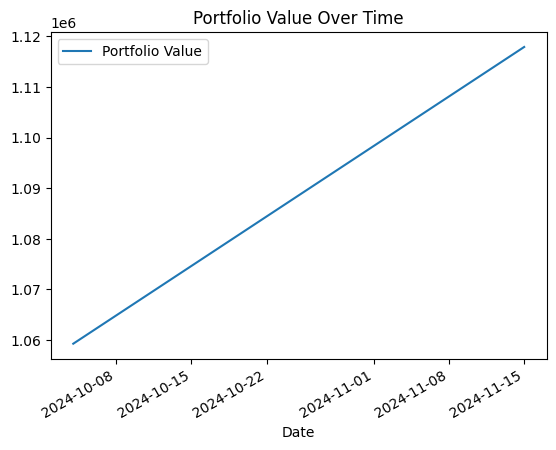

In [6]:
def backtest_strategy(stock_data, selected_stocks, lookback_period, portfolio_size, rebalance_period=30):
    """
    Backtest the momentum strategy.
    """
    dates = stock_data.index.get_level_values(0).unique()
    start_date = dates[0]
    end_date = dates[-1]
    portfolio_value = portfolio_size
    portfolio_history = []
    portfolio_weights = {ticker: 0 for ticker in selected_stocks}
    
    for current_date in dates[::rebalance_period]:
        # Fetch stock prices on the rebalance date
        current_prices = {ticker: stock_data[ticker]['Adj Close'].loc[current_date] for ticker in selected_stocks if current_date in stock_data[ticker].index}
        
        # Calculate portfolio allocation
        equal_allocation = portfolio_value / len(selected_stocks)
        for ticker in selected_stocks:
            portfolio_weights[ticker] = equal_allocation / current_prices[ticker]
        
        # Calculate portfolio value for the next period
        next_period_end = min(dates[dates > current_date][:rebalance_period][-1], end_date)
        if not next_period_end:
            break

        next_prices = {ticker: stock_data[ticker]['Adj Close'].loc[next_period_end] for ticker in selected_stocks if next_period_end in stock_data[ticker].index}
        portfolio_value = sum(portfolio_weights[ticker] * next_prices.get(ticker, 0) for ticker in selected_stocks)
        
        portfolio_history.append({'Date': current_date, 'Portfolio Value': portfolio_value})
    
    portfolio_df = pd.DataFrame(portfolio_history)
    return portfolio_df

def calculate_metrics(portfolio_df):
    """
    Calculate portfolio metrics: return, volatility, and Sharpe Ratio.
    """
    # Calculate returns
    portfolio_df['Daily Return'] = portfolio_df['Portfolio Value'].pct_change()
    cumulative_return = (portfolio_df['Portfolio Value'].iloc[-1] / portfolio_df['Portfolio Value'].iloc[0]) - 1
    annualized_return = ((1 + cumulative_return) ** (252 / len(portfolio_df))) - 1
    
    # Calculate volatility
    daily_volatility = portfolio_df['Daily Return'].std()
    annualized_volatility = daily_volatility * np.sqrt(252)
    
    # Calculate Sharpe Ratio
    risk_free_rate = 0.02  # Assume 2% annual risk-free rate
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    return {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio
    }

# Example usage
portfolio_df = backtest_strategy(stock_data, diversified_stocks, LOOKBACK_DAYS, portfolio_size)
metrics = calculate_metrics(portfolio_df)

print("Backtest Results:")
print(portfolio_df)
print("Performance Metrics:")
print(metrics)

# Plot portfolio value over time
portfolio_df.plot(x='Date', y='Portfolio Value', title="Portfolio Value Over Time")


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")


# Constants
LOOKBACK_DAYS = 30  # Lookback period for momentum calculation
MIN_AVERAGE_VOLUME = 1000000  # Minimum average volume for liquidity filter
MOMENTUM_THRESHOLD = 0.02  # Minimum return over the lookback period for momentum
MAX_SELECTED_STOCKS = 30  # Maximum number of stocks to select
PORTFOLIO_SIZE = 1000000  # Example portfolio size: $1,000,000
REBALANCE_PERIOD = 5  # Rebalance every 5 trading days
START_DATE = "2023-10-01"  # Start of backtesting period
END_DATE = "2024-10-01"  # End of backtesting period
DATA_START_DATE = "2023-09-01"  # Fetch data from an earlier period


def get_sp500_tickers():
    """
    Fetch the list of S&P 500 tickers from Wikipedia.
    """
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(url, header=0)
    sp500 = table[0]
    tickers = sp500['Symbol'].tolist()
    return tickers


def fetch_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date, interval='1d', group_by='ticker', progress=False)
    
    # Flatten the columns for easier access
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
    
    # Remove time zones from the index
    data.index = data.index.tz_localize(None)
    
    # Remove tickers with no valid data
    valid_tickers = [ticker for ticker in tickers if f"{ticker}_Adj Close" in data.columns]
    if len(valid_tickers) < len(tickers):
        print(f"Invalid tickers removed: {set(tickers) - set(valid_tickers)}")
    return data


def calculate_correlation_matrix(data):
    """
    Calculate the correlation matrix for daily returns of all stocks.
    """
    # Extract adjusted close prices
    adj_close_cols = [col for col in data.columns if col.endswith('_Adj Close')]
    returns = data[adj_close_cols].pct_change().dropna()  # Calculate daily returns

    # Rename columns to tickers for easier handling
    returns.columns = [col.split('_')[0] for col in returns.columns]

    # Calculate correlation matrix
    correlation_matrix = returns.corr()
    return correlation_matrix


def select_low_correlation_stocks(correlation_matrix, num_stocks):
    """
    Select stocks with the lowest average correlation.
    """
    # Calculate average correlation for each stock
    avg_correlation = correlation_matrix.mean(axis=1)

    # Sort by average correlation and select the top `num_stocks`
    selected_stocks = avg_correlation.nsmallest(num_stocks).index.tolist()
    return selected_stocks

def filter_stocks(data, current_date):
    """
    Filter stocks based on momentum and volume criteria up to the given date.
    """
    filtered_stocks = []
    adj_close_cols = [col for col in data.columns if col.endswith('_Adj Close')]
    volume_cols = [col.replace('_Adj Close', '_Volume') for col in adj_close_cols]

    for adj_close, volume in zip(adj_close_cols, volume_cols):
        try:
            ticker = adj_close.split('_')[0]

            # Subset data up to the current date
            stock_data = data.loc[:current_date, [adj_close, volume]].dropna()

            # Ensure we have enough data for the lookback period
            if len(stock_data) < LOOKBACK_DAYS:
                continue

            # Calculate momentum and average volume
            momentum = (stock_data[adj_close].iloc[-1] / stock_data[adj_close].iloc[-LOOKBACK_DAYS]) - 1
            avg_volume = stock_data[volume].mean()

            # Apply filtering criteria
            if momentum > MOMENTUM_THRESHOLD and avg_volume > MIN_AVERAGE_VOLUME:
                filtered_stocks.append(ticker)
        except Exception as e:
            print(f"Error processing {adj_close}: {e}")

    return filtered_stocks


def backtest_strategy(data, portfolio_size, rebalance_period, start_date, end_date, num_stocks=30):
    """
    Perform backtesting of the momentum strategy with low correlation stocks.
    """
    portfolio_value = portfolio_size
    portfolio_history = []
    dates = pd.date_range(start=start_date, end=end_date, freq='B')

    for i in range(0, len(dates), rebalance_period):
        current_date = dates[i]
        next_date = dates[min(i + rebalance_period, len(dates) - 1)]

        if current_date not in data.index or next_date not in data.index:
            print(f"Skipping non-trading day: {current_date} or {next_date}")
            continue

        # Filter stocks based on momentum and volume
        filtered_stocks = filter_stocks(data, current_date)

        # Calculate correlation matrix for filtered stocks
        adj_close_cols = [f"{ticker}_Adj Close" for ticker in filtered_stocks]
        filtered_data = data[adj_close_cols].dropna()
        correlation_matrix = calculate_correlation_matrix(filtered_data)

        # Select low-correlation stocks from the filtered list
        selected_stocks = select_low_correlation_stocks(correlation_matrix, num_stocks)
        print(f"Selected Stocks on {current_date}: {selected_stocks}")

        # Get current and next prices for selected stocks
        current_prices = {
            ticker: data.get(f"{ticker}_Adj Close", pd.Series()).get(current_date, 0)
            for ticker in selected_stocks
        }
        next_prices = {
            ticker: data.get(f"{ticker}_Adj Close", pd.Series()).get(next_date, 0)
            for ticker in selected_stocks
        }

        print(f"Current prices on {current_date}: {current_prices}")
        print(f"Next prices on {next_date}: {next_prices}")

        # Check valid prices
        valid_prices = {ticker: price for ticker, price in current_prices.items() if price > 0}
        if not valid_prices:
            print("No valid stocks for rebalance. Skipping...")
            continue

        # Calculate portfolio value
        equal_allocation = portfolio_value / len(valid_prices)
        portfolio_weights = {ticker: equal_allocation / price for ticker, price in valid_prices.items()}

        portfolio_value = sum(
            portfolio_weights[ticker] * next_prices.get(ticker, 0) for ticker in portfolio_weights
        )
        print(f"Portfolio value after rebalance: {portfolio_value}")

        portfolio_history.append({"Date": current_date, "Portfolio Value": portfolio_value})

    return pd.DataFrame(portfolio_history)


def calculate_metrics(portfolio_df):
    """
    Calculate performance metrics for the portfolio.
    """
    if portfolio_df.empty:
        return {"Return": 0, "Sharpe Ratio": 0}
    
    # Calculate total return
    total_return = (portfolio_df['Portfolio Value'].iloc[-1] / portfolio_df['Portfolio Value'].iloc[0]) - 1
    
    # Calculate daily returns
    portfolio_df['Daily Return'] = portfolio_df['Portfolio Value'].pct_change()
    sharpe_ratio = portfolio_df['Daily Return'].mean() / portfolio_df['Daily Return'].std() * np.sqrt(252)
    
    return {"Total Return": total_return, "Sharpe Ratio": sharpe_ratio}


# Main Workflow
print("Fetching S&P 500 tickers...")
sp500_tickers = get_sp500_tickers()

print("Downloading historical stock data...")
stock_data = fetch_data(sp500_tickers, DATA_START_DATE, END_DATE)

print("Backtesting strategy...")
portfolio_df = backtest_strategy(stock_data, PORTFOLIO_SIZE, REBALANCE_PERIOD, START_DATE, END_DATE, num_stocks=30)

if not portfolio_df.empty:
    print("Calculating performance metrics...")
    metrics = calculate_metrics(portfolio_df)
    print("Performance Metrics:", metrics)

    # Plot Portfolio Value
    portfolio_df.plot(x='Date', y='Portfolio Value', title="Portfolio Value Over Time")
    plt.show()
else:
    print("No portfolio data available for performance metrics.")


Fetching S&P 500 tickers...


Failed to get ticker 'BRK.B' reason: Expecting value: line 1 column 1 (char 0)

503 Failed downloads:
['TXT', 'WST', 'GOOGL', 'MRK', 'TRGP', 'KR', 'TPR', 'PEG', 'TTWO', 'DECK', 'TDY', 'CARR', 'NVR', 'BAX', 'AMGN', 'BLDR', 'BA', 'HSY', 'CSX', 'MKTX', 'ARE', 'ECL', 'STX', 'LOW', 'BALL', 'PM', 'TEL', 'SPG', 'SMCI', 'ZBRA', 'ABT', 'DOV', 'LULU', 'REGN', 'LMT', 'CDW', 'CSGP', 'EFX', 'JNJ', 'GE', 'KEYS', 'IR', 'BKNG', 'LYB', 'VST', 'RSG', 'ADBE', 'SOLV', 'F', 'MMC', 'APA', 'ADSK', 'EQT', 'FOXA', 'FICO', 'MSFT', 'FDS', 'FTNT', 'WRB', 'ITW', 'MAS', 'BRO', 'BXP', 'JPM', 'PSA', 'QRVO', 'EQIX', 'MS', 'MCHP', 'IPG', 'VTR', 'RTX', 'USB', 'ABNB', 'AXON', 'TRV', 'COP', 'WBD', 'UDR', 'HAL', 'BMY', 'WYNN', 'SBAC', 'PARA', 'GPC', 'PNW', 'BKR', 'AFL', 'MKC', 'NSC', 'BAC', 'HRL', 'DRI', 'DLTR', 'CAH', 'DHI', 'HOLX', 'CRM', 'RMD', 'PFG', 'DUK', 'FFIV', 'MSCI', 'INCY', 'SYY', 'DGX', 'MGM', 'PH', 'AWK', 'CPT', 'SNPS', 'DXCM', 'CTAS', 'AZO', 'EVRG', 'NI', 'CVX', 'EIX', 'NTAP', 'ABBV', 'CEG', 'GM', 'APTV', 'OM

Backtesting strategy...
Skipping non-trading day: 2023-10-02 00:00:00 or 2023-10-09 00:00:00
Skipping non-trading day: 2023-10-09 00:00:00 or 2023-10-16 00:00:00
Skipping non-trading day: 2023-10-16 00:00:00 or 2023-10-23 00:00:00
Skipping non-trading day: 2023-10-23 00:00:00 or 2023-10-30 00:00:00
Skipping non-trading day: 2023-10-30 00:00:00 or 2023-11-06 00:00:00
Skipping non-trading day: 2023-11-06 00:00:00 or 2023-11-13 00:00:00
Skipping non-trading day: 2023-11-13 00:00:00 or 2023-11-20 00:00:00
Skipping non-trading day: 2023-11-20 00:00:00 or 2023-11-27 00:00:00
Skipping non-trading day: 2023-11-27 00:00:00 or 2023-12-04 00:00:00
Skipping non-trading day: 2023-12-04 00:00:00 or 2023-12-11 00:00:00
Skipping non-trading day: 2023-12-11 00:00:00 or 2023-12-18 00:00:00
Skipping non-trading day: 2023-12-18 00:00:00 or 2023-12-25 00:00:00
Skipping non-trading day: 2023-12-25 00:00:00 or 2024-01-01 00:00:00
Skipping non-trading day: 2024-01-01 00:00:00 or 2024-01-08 00:00:00
Skipping n

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")


# Constants
LOOKBACK_DAYS = 30  # Lookback period for momentum calculation
MIN_AVERAGE_VOLUME = 1000000  # Minimum average volume for liquidity filter
MOMENTUM_THRESHOLD = 0.02  # Minimum return over the lookback period for momentum
MAX_SELECTED_STOCKS = 30  # Maximum number of stocks to select
PORTFOLIO_SIZE = 1000000  # Example portfolio size: $1,000,000
REBALANCE_PERIOD = 5  # Rebalance every 5 trading days
START_DATE = "2023-10-01"  # Start of backtesting period
END_DATE = "2024-10-01"  # End of backtesting period
DATA_START_DATE = "2023-08-01"  # Fetch data from an earlier period


def get_sp500_tickers():
    """
    Fetch the list of S&P 500 tickers from Wikipedia.
    """
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(url, header=0)
    sp500 = table[0]
    tickers = sp500['Symbol'].tolist()
    return tickers


def fetch_data(tickers, start_date, end_date):
    """
    Fetch data for the list of tickers, handling errors gracefully.
    """
    try:
        # Fetch data from Yahoo Finance
        data = yf.download(
            tickers, 
            start=start_date, 
            end=end_date, 
            interval='1d', 
            group_by='ticker', 
            progress=False
        )

        # Print debug information about the data
        print(f"Data fetched successfully. Data structure:\n")
        print(data.head())
        print(data.info())

        # Flatten MultiIndex columns (if necessary)
        print("Flattening MultiIndex columns...")
        data.columns = ['_'.join(col).strip() for col in data.columns.values]

        # Print structure again after flattening
        print("Data structure after flattening (if applicable):\n")
        print(data.head())
        print(data.info())

        return data

    except Exception as e:
        print(f"An error occurred while fetching data: {e}")
        return pd.DataFrame()  # Return an empty DataFrame if an exception occurs



def calculate_correlation_matrix(data):
    """
    Calculate the correlation matrix for daily returns of all stocks.
    """
    # Extract adjusted close prices
    adj_close_cols = [col for col in data.columns if col.endswith('_Adj Close')]
    returns = data[adj_close_cols].pct_change().dropna()  # Calculate daily returns

    # Rename columns to tickers for easier handling
    returns.columns = [col.split('_')[0] for col in returns.columns]

    # Calculate correlation matrix
    correlation_matrix = returns.corr()
    return correlation_matrix


def select_low_correlation_stocks(correlation_matrix, num_stocks):
    """
    Select stocks with the lowest average correlation.
    """
    # Calculate average correlation for each stock
    avg_correlation = correlation_matrix.mean(axis=1)

    # Sort by average correlation and select the top num_stocks
    selected_stocks = avg_correlation.nsmallest(num_stocks).index.tolist()
    return selected_stocks

def filter_stocks(data, current_date):
    """
    Filter stocks based on momentum and volume criteria up to the given date.
    """
    filtered_stocks = []
    adj_close_cols = [col for col in data.columns if col.endswith('_Adj Close')]
    volume_cols = [col.replace('_Adj Close', '_Volume') for col in adj_close_cols]

    for adj_close, volume in zip(adj_close_cols, volume_cols):
        try:
            ticker = adj_close.split('_')[0]

            # Subset data up to the current date
            stock_data = data.loc[:current_date, [adj_close, volume]].dropna()

            # Ensure we have enough data for the lookback period
            if len(stock_data) < LOOKBACK_DAYS:
                continue

            # Calculate momentum and average volume
            momentum = (stock_data[adj_close].iloc[-1] / stock_data[adj_close].iloc[-LOOKBACK_DAYS]) - 1
            avg_volume = stock_data[volume].mean()

            # Apply filtering criteria
            if momentum > MOMENTUM_THRESHOLD and avg_volume > MIN_AVERAGE_VOLUME:
                filtered_stocks.append(ticker)
        except Exception as e:
            print(f"Error processing {adj_close}: {e}")

    return filtered_stocks


def backtest_strategy(data, portfolio_size, rebalance_period, start_date, end_date, num_stocks=30):
    """
    Perform backtesting of the momentum strategy with low correlation stocks.
    """
    portfolio_value = portfolio_size
    portfolio_history = []
    dates = pd.date_range(start=start_date, end=end_date, freq='B')

    for i in range(0, len(dates), rebalance_period):
        current_date = dates[i]
        next_date = dates[min(i + rebalance_period, len(dates) - 1)]

        if current_date not in data.index or next_date not in data.index:
            print(f"Skipping non-trading day: {current_date} or {next_date}")
            continue

        # Filter stocks based on momentum and volume
        filtered_stocks = filter_stocks(data, current_date)

        # Calculate correlation matrix for filtered stocks
        adj_close_cols = [f"{ticker}_Adj Close" for ticker in filtered_stocks]
        filtered_data = data[adj_close_cols].dropna()
        correlation_matrix = calculate_correlation_matrix(filtered_data)

        # Select low-correlation stocks from the filtered list
        selected_stocks = select_low_correlation_stocks(correlation_matrix, num_stocks)
        print(f"Selected Stocks on {current_date}: {selected_stocks}")

        # Get current and next prices for selected stocks
        current_prices = {
            ticker: data.get(f"{ticker}_Adj Close", pd.Series()).get(current_date, 0)
            for ticker in selected_stocks
        }
        next_prices = {
            ticker: data.get(f"{ticker}_Adj Close", pd.Series()).get(next_date, 0)
            for ticker in selected_stocks
        }

        print(f"Current prices on {current_date}: {current_prices}")
        print(f"Next prices on {next_date}: {next_prices}")

        # Check valid prices
        valid_prices = {ticker: price for ticker, price in current_prices.items() if price > 0}
        if not valid_prices:
            print("No valid stocks for rebalance. Skipping...")
            continue

        # Calculate portfolio value
        equal_allocation = portfolio_value / len(valid_prices)
        portfolio_weights = {ticker: equal_allocation / price for ticker, price in valid_prices.items()}

        portfolio_value = sum(
            portfolio_weights[ticker] * next_prices.get(ticker, 0) for ticker in portfolio_weights
        )
        print(f"Portfolio value after rebalance: {portfolio_value}")

        portfolio_history.append({"Date": current_date, "Portfolio Value": portfolio_value})

    return pd.DataFrame(portfolio_history)


def calculate_metrics(portfolio_df):
    """
    Calculate performance metrics for the portfolio.
    """
    if portfolio_df.empty:
        return {"Return": 0, "Sharpe Ratio": 0}
    
    # Calculate total return
    total_return = (portfolio_df['Portfolio Value'].iloc[-1] / portfolio_df['Portfolio Value'].iloc[0]) - 1
    
    # Calculate daily returns
    portfolio_df['Daily Return'] = portfolio_df['Portfolio Value'].pct_change()
    sharpe_ratio = portfolio_df['Daily Return'].mean() / portfolio_df['Daily Return'].std() * np.sqrt(252)
    
    return {"Total Return": total_return, "Sharpe Ratio": sharpe_ratio}


# Main Workflow
print("Fetching S&P 500 tickers...")
sp500_tickers = get_sp500_tickers()

print("Downloading historical stock data...")
stock_data = fetch_data(sp500_tickers, START_DATE, END_DATE)

print("Backtesting strategy...")
portfolio_df = backtest_strategy(stock_data, PORTFOLIO_SIZE, REBALANCE_PERIOD, START_DATE, END_DATE, num_stocks=30)

if not portfolio_df.empty:
    print("Calculating performance metrics...")
    metrics = calculate_metrics(portfolio_df)
    print("Performance Metrics:", metrics)

    # Plot Portfolio Value
    portfolio_df.plot(x='Date', y='Portfolio Value', title="Portfolio Value Over Time")
    plt.show()
else:
    print("No portfolio data available for performance metrics.")

Fetching S&P 500 tickers...



141 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-10-01 -> 2024-10-01)')
['LW', 'MLM', 'LUV', 'LLY', 'LYV', 'MA', 'SBUX', 'LIN', 'PAYC', 'CHTR', 'CTSH', 'FITB', 'CNP', 'RF', 'DOW', 'WTW', 'NUE', 'GRMN', 'FI', 'NKE', 'IP', 'PANW', 'CTRA', 'GPN', 'AKAM', 'POOL', 'FAST', 'BR', 'PNC', 'FTV', 'ULTA', 'PPL', 'LNT', 'FOX', 'MTD', 'CE', 'EXPD', 'ANET', 'ESS', 'APD', 'NEM', 'STE', 'FDX', 'VLO', 'KKR', 'CPB', 'BG', 'NCLH', 'IVZ', 'WAT', 'MDLZ', 'PODD', 'GLW', 'WEC', 'CL', 'PFE', 'DIS', 'VLTO', 'EXR', 'ODFL', 'HUM', 'MTB', 'PYPL', 'FIS', 'NFLX', 'PSX', 'VRSN', 'APH', 'OTIS', 'TRMB', 'SYK', 'MTCH', 'FRT', 'KMI', 'AES', 'KDP', 'PKG', 'EPAM', 'ED', 'MSI', 'TMO', 'HAS', 'BEN', 'EG', 'TJX', 'UAL', 'MRNA', 'AMT', 'INTC', 'DVA', 'CBRE', 'SWKS', 'LKQ', 'WFC', 'GL', 'VRSK', 'AVB', 'GWW', 'ACN', 'GEHC', 'LVS', 'CME', 'CFG', 'DPZ', 'TMUS', 'IEX', 'IQV', 'DTE', 'HUBB

Data fetched successfully. Data structure:

Ticker                          CTVA                                   \
Price                           Open       High        Low      Close   
Date                                                                    
2023-10-02 00:00:00+00:00  50.939999  50.939999  49.730000  50.049999   
2023-10-03 00:00:00+00:00  49.549999  50.630001  49.410000  50.340000   
2023-10-04 00:00:00+00:00  50.509998  51.020000  50.145000  50.450001   
2023-10-05 00:00:00+00:00  50.130001  50.529999  49.430000  49.830002   
2023-10-06 00:00:00+00:00  49.669998  50.490002  49.439999  50.049999   

Ticker                                               META              \
Price                      Adj Close   Volume        Open        High   
Date                                                                    
2023-10-02 00:00:00+00:00  49.437397  3666300  302.739990  307.179993   
2023-10-03 00:00:00+00:00  49.723854  3856900  304.260010  306.769989   
2023-1

KeyError: 'Date'

In [14]:
print(sp500_tickers)
stock_data.head()

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMTM', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', '

""


In [19]:
selected = ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMTM', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DAY', 'DECK', 'DE', 'DELL', 'DAL', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DHI', 'DTE', 'DUK', 'DD', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EQT', 'EFX', 'EQIX', 'EQR', 'ERIE', 'ESS', 'EL', 'EG', 'EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FICO', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FI', 'FMC', 'F', 'FTNT', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GE', 'GEHC', 'GEV', 'GEN', 'GNRC', 'GD', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GL', 'GDDY', 'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'DOC', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUBB', 'HUM', 'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'INCY', 'IR', 'PODD', 'INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'INVH', 'IQV', 'IRM', 'JBHT', 'JBL', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K', 'KVUE', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KKR', 'KLAC', 'KHC', 'KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LLY', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LULU', 'LYB', 'MTB', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA', 'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE', 'NI', 'NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PLTR', 'PANW', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PEP', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RVTY', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SW', 'SNA', 'SOLV', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SMCI', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TPL', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UBER', 'UDR', 'ULTA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VLTO', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VTRS', 'VICI', 'V', 'VST', 'VMC', 'WRB', 'GWW', 'WAB', 'WBA', 'WMT', 'DIS', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WY', 'WMB', 'WTW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZTS']


data = yf.download(
            selected, 
            start="2023-09-01", 
            end="2024-09-01", 
            interval='1d', 
            group_by='ticker', 
            progress=False
        )

print(data)

Failed to get ticker 'BRK.B' reason: Expecting value: line 1 column 1 (char 0)

169 Failed downloads:
['AMTM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-09-01 -> 2024-09-01) (Yahoo error = "Data doesn\'t exist for startDate = 1693540800, endDate = 1725163200")')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-09-01 -> 2024-09-01)')
['PPG', 'MNST', 'ROK', 'URI', 'ANSS', 'ORCL', 'DVN', 'EMR', 'KHC', 'BSX', 'PLD', 'EBAY', 'CDNS', 'ELV', 'LRCX', 'AVGO', 'TFX', 'GIS', 'CRL', 'T', 'GS', 'TFC', 'KMX', 'TPL', 'LUV', 'LLY', 'RF', 'TER', 'LW', 'MA', 'ISRG', 'PAYC', 'BBY', 'FITB', 'MLM', 'CTSH', 'WTW', 'CNP', 'LIN', 'DOW', 'FI', 'GRMN', 'PANW', 'LYV', 'NKE', 'SBUX', 'NUE', 'CHTR', 'PPL', 'IP', 'ULTA', 'CTRA', 'AKAM', 'AON', 'GPN', 'FAST', 'POOL', 'CE', 'BR', 'APD', 'FTV', 'ERIE', 'PNC', 'NEM', 'ESS', 'LH', 'MTD', 'ANET', 'FDX', 'NCLH', 'ALLE', 'EMN', 'FE', 'CPB', 'PCG', 'KKR', 'EL', 'DIS', 'WEC', 'CL', 'WAT', 'PO

Ticker                          CTVA                                   \
Price                           Open       High        Low      Close   
Date                                                                    
2023-09-01 00:00:00+00:00  51.000000  51.400002  50.849998  51.110001   
2023-09-05 00:00:00+00:00  51.529999  51.900002  50.950001  50.959999   
2023-09-06 00:00:00+00:00  50.849998  51.009998  50.160000  50.500000   
2023-09-07 00:00:00+00:00  50.139999  50.639999  48.840000  49.560001   
2023-09-08 00:00:00+00:00  49.680000  49.919998  49.259998  49.580002   
...                              ...        ...        ...        ...   
2024-08-26 00:00:00+00:00  55.799999  56.275002  55.380001  55.650002   
2024-08-27 00:00:00+00:00  55.340000  55.650002  54.950001  55.560001   
2024-08-28 00:00:00+00:00  55.520000  56.040001  55.090000  56.000000   
2024-08-29 00:00:00+00:00  56.500000  57.415001  55.869999  57.000000   
2024-08-30 00:00:00+00:00  56.770000  57.570000  56

Fetching S&P 500 tickers...



2 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-08-01 -> 2024-10-01)')


Backtesting strategy...
Selected Stocks on 2023-10-02 00:00:00: ['UNH', 'T', 'PGR', 'CI', 'CVS', 'CNC', 'ACGL', 'ALL', 'TMUS', 'WRB', 'AFL', 'IP', 'DELL', 'CHTR', 'XOM', 'FDX', 'BSX', 'CB', 'CF', 'AMGN', 'AKAM', 'VST', 'IFF', 'TSLA', 'SMCI', 'CRWD', 'META', 'GDDY', 'MPC', 'ISRG']
Current prices on 2023-10-02 00:00:00: {'UNH': 506.851806640625, 'T': 13.555564880371094, 'PGR': 137.99005126953125, 'CI': 282.74945068359375, 'CVS': 66.32257843017578, 'CNC': 69.30000305175781, 'ACGL': 75.47281646728516, 'ALL': 107.92894744873047, 'TMUS': 136.63894653320312, 'WRB': 40.97577667236328, 'AFL': 74.47016143798828, 'IP': 33.5136833190918, 'DELL': 66.2945327758789, 'CHTR': 438.5, 'XOM': 110.8025894165039, 'FDX': 259.8319091796875, 'BSX': 52.810001373291016, 'CB': 203.5828399658203, 'CF': 81.20623779296875, 'AMGN': 256.48260498046875, 'AKAM': 106.83000183105469, 'VST': 32.0753059387207, 'IFF': 64.4864273071289, 'TSLA': 251.60000610351562, 'SMCI': 28.88599967956543, 'CRWD': 169.5399932861328, 'META': 

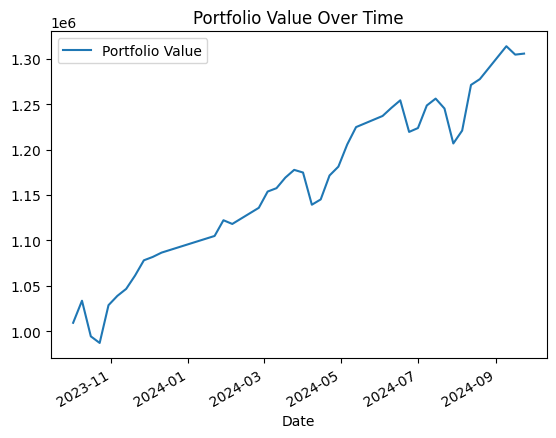

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")


# Constants
LOOKBACK_DAYS = 30  # Lookback period for momentum calculation
MIN_AVERAGE_VOLUME = 1000000  # Minimum average volume for liquidity filter
MOMENTUM_THRESHOLD = 0.02  # Minimum return over the lookback period for momentum
MAX_SELECTED_STOCKS = 30  # Maximum number of stocks to select
PORTFOLIO_SIZE = 1000000  # Example portfolio size: $1,000,000
REBALANCE_PERIOD = 5  # Rebalance every 5 trading days
START_DATE = "2023-10-01"  # Start of backtesting period
END_DATE = "2024-10-01"  # End of backtesting period
DATA_START_DATE = "2023-08-01"  # Fetch data from an earlier period


def get_sp500_tickers():
    """
    Fetch the list of S&P 500 tickers from Wikipedia.
    """
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(url, header=0)
    sp500 = table[0]
    tickers = sp500['Symbol'].tolist()
    return tickers


def fetch_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date, interval='1d', group_by='ticker', progress=False)
    
    # Flatten the columns for easier access
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
    
    # Remove time zones from the index
    data.index = data.index.tz_localize(None)
    
    # Remove tickers with no valid data
    valid_tickers = [ticker for ticker in tickers if f"{ticker}_Adj Close" in data.columns]
    if len(valid_tickers) < len(tickers):
        print(f"Invalid tickers removed: {set(tickers) - set(valid_tickers)}")
    return data


def calculate_correlation_matrix(data):
    """
    Calculate the correlation matrix for daily returns of all stocks.
    """
    # Extract adjusted close prices
    adj_close_cols = [col for col in data.columns if col.endswith('_Adj Close')]
    returns = data[adj_close_cols].pct_change().dropna()  # Calculate daily returns

    # Rename columns to tickers for easier handling
    returns.columns = [col.split('_')[0] for col in returns.columns]

    # Calculate correlation matrix
    correlation_matrix = returns.corr()
    return correlation_matrix


def select_low_correlation_stocks(correlation_matrix, num_stocks):
    """
    Select stocks with the lowest average correlation.
    """
    # Calculate average correlation for each stock
    avg_correlation = correlation_matrix.mean(axis=1)

    # Sort by average correlation and select the top num_stocks
    selected_stocks = avg_correlation.nsmallest(num_stocks).index.tolist()
    return selected_stocks

def filter_stocks(data, current_date):
    """
    Filter stocks based on momentum and volume criteria up to the given date.
    """
    filtered_stocks = []
    adj_close_cols = [col for col in data.columns if col.endswith('_Adj Close')]
    volume_cols = [col.replace('_Adj Close', '_Volume') for col in adj_close_cols]

    for adj_close, volume in zip(adj_close_cols, volume_cols):
        try:
            ticker = adj_close.split('_')[0]

            # Subset data up to the current date
            stock_data = data.loc[:current_date, [adj_close, volume]].dropna()

            # Ensure we have enough data for the lookback period
            if len(stock_data) < LOOKBACK_DAYS:
                continue

            # Calculate momentum and average volume
            momentum = (stock_data[adj_close].iloc[-1] / stock_data[adj_close].iloc[-LOOKBACK_DAYS]) - 1
            avg_volume = stock_data[volume].mean()

            # Apply filtering criteria
            if momentum > MOMENTUM_THRESHOLD and avg_volume > MIN_AVERAGE_VOLUME:
                filtered_stocks.append(ticker)
        except Exception as e:
            print(f"Error processing {adj_close}: {e}")

    return filtered_stocks


def backtest_strategy(data, portfolio_size, rebalance_period, start_date, end_date, num_stocks=30):
    """
    Perform backtesting of the momentum strategy with low correlation stocks.
    """
    portfolio_value = portfolio_size
    portfolio_history = []
    dates = pd.date_range(start=start_date, end=end_date, freq='B')

    for i in range(0, len(dates), rebalance_period):
        current_date = dates[i]
        next_date = dates[min(i + rebalance_period, len(dates) - 1)]

        if current_date not in data.index or next_date not in data.index:
            print(f"Skipping non-trading day: {current_date} or {next_date}")
            continue

        # Filter stocks based on momentum and volume
        filtered_stocks = filter_stocks(data, current_date)

        # Calculate correlation matrix for filtered stocks
        adj_close_cols = [f"{ticker}_Adj Close" for ticker in filtered_stocks]
        filtered_data = data[adj_close_cols].dropna()
        correlation_matrix = calculate_correlation_matrix(filtered_data)

        # Select low-correlation stocks from the filtered list
        selected_stocks = select_low_correlation_stocks(correlation_matrix, num_stocks)
        print(f"Selected Stocks on {current_date}: {selected_stocks}")

        # Get current and next prices for selected stocks
        current_prices = {
            ticker: data.get(f"{ticker}_Adj Close", pd.Series()).get(current_date, 0)
            for ticker in selected_stocks
        }
        next_prices = {
            ticker: data.get(f"{ticker}_Adj Close", pd.Series()).get(next_date, 0)
            for ticker in selected_stocks
        }

        print(f"Current prices on {current_date}: {current_prices}")
        print(f"Next prices on {next_date}: {next_prices}")

        # Check valid prices
        valid_prices = {ticker: price for ticker, price in current_prices.items() if price > 0}
        if not valid_prices:
            print("No valid stocks for rebalance. Skipping...")
            continue

        # Calculate portfolio value
        equal_allocation = portfolio_value / len(valid_prices)
        portfolio_weights = {ticker: equal_allocation / price for ticker, price in valid_prices.items()}

        portfolio_value = sum(
            portfolio_weights[ticker] * next_prices.get(ticker, 0) for ticker in portfolio_weights
        )
        print(f"Portfolio value after rebalance: {portfolio_value}")

        portfolio_history.append({"Date": current_date, "Portfolio Value": portfolio_value})

    return pd.DataFrame(portfolio_history)


def calculate_metrics(portfolio_df):
    """
    Calculate performance metrics for the portfolio.
    """
    if portfolio_df.empty:
        return {"Return": 0, "Sharpe Ratio": 0}
    
    # Calculate total return
    total_return = (portfolio_df['Portfolio Value'].iloc[-1] / portfolio_df['Portfolio Value'].iloc[0]) - 1
    
    # Calculate daily returns
    portfolio_df['Daily Return'] = portfolio_df['Portfolio Value'].pct_change()
    sharpe_ratio = portfolio_df['Daily Return'].mean() / portfolio_df['Daily Return'].std() * np.sqrt(252)
    
    return {"Total Return": total_return, "Sharpe Ratio": sharpe_ratio}


# Main Workflow
print("Fetching S&P 500 tickers...")
sp500_tickers = get_sp500_tickers()

print("Downloading historical stock data...")
stock_data = fetch_data(sp500_tickers, DATA_START_DATE, END_DATE)

print("Backtesting strategy...")
portfolio_df = backtest_strategy(stock_data, PORTFOLIO_SIZE, REBALANCE_PERIOD, START_DATE, END_DATE, num_stocks=30)

if not portfolio_df.empty:
    print("Calculating performance metrics...")
    metrics = calculate_metrics(portfolio_df)
    print("Performance Metrics:", metrics)

    # Plot Portfolio Value
    portfolio_df.plot(x='Date', y='Portfolio Value', title="Portfolio Value Over Time")
    plt.show()
else:
    print("No portfolio data available for performance metrics.")

In [11]:
current_prices = {
    ticker: data[ticker]['Adj Close'].get(current_date, 0) for ticker in selected_stocks
    if current_date in data[ticker].index
}

NameError: name 'selected_stocks' is not defined